#Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sweetviz missingno

     |████████████████████████████████| 15.1MB 310kB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


##Import libraries

In [ ]:
#basic library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import sweetviz as sv
from scipy.stats import kurtosis
from scipy.stats import skew
import missingno as ms

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Define functions

In [ ]:
#Functions

#Split dataframe by data types
def split_dataframe(dataframe):
  cat_dataframe = pd.DataFrame(dataframe.iloc[:,0:2])
  cont_dataframe = pd.DataFrame(dataframe.iloc[:,0:2])
  col = list(dataframe.columns)
  col.pop(0)
  col.pop(0)
  for c in col:
    if dataframe[c].dtypes == 'object':
      cat_dataframe = pd.concat([cat_dataframe, dataframe[c]], axis = 1)
    elif dataframe[c].isin([0,1,'Nan']).all():
        cat_dataframe = pd.concat([cat_dataframe, dataframe[c]], axis = 1)
    else:
      cont_dataframe = pd.concat([cont_dataframe, dataframe[c]], axis = 1)
  cat = cat_dataframe
  cont = cont_dataframe
  return cat, cont

#Organize aggregation of datasets
def organize_agg(dataframe, stat, name):
  columns = []
  for var in dataframe.columns.levels[0]:
    for stat in dataframe.columns.levels[1][:]:
      columns.append('%s_%s_%s' % (name, var, stat))
  dataframe.columns = columns
  return dataframe

#Number of missing values in the dataframe application
def missing_values(dataframe):
  number_MV = pd.DataFrame({'Count' : dataframe.isnull().sum(),
                          '%': dataframe.isnull().sum()/len(dataframe)})
  print(number_MV.astype(bool).sum(axis=0)[0], 'Columns with missing values')
  return number_MV.sort_values('Count', ascending=False)


#Datasets

In [ ]:
#Load Dataset
path = '/content/drive/MyDrive/DS/CreditRisk/home-credit-default-risk/'
application_train = pd.read_csv(path + 'application_train.csv')
bureau = pd.read_csv(path + 'bureau.csv')
bureau_balance = pd.read_csv(path + 'bureau_balance.csv')
pos_cash_balance = pd.read_csv(path + 'POS_CASH_balance.csv')
credit_card_balance = pd.read_csv(path + 'credit_card_balance.csv')
previous_application = pd.read_csv(path + 'previous_application.csv')
installments_payments = pd.read_csv(path + 'installments_payments.csv')
test_application = pd.read_csv(path + 'application_test.csv')

#EDA

##Application Dataset

A handy Python library to address this step is the sweetviz. This library automates the part of the EDA process providing a report that includes the number of missing values for each feature, descriptive statistics of each feature (average, median, quantiles, standard deviation…), type of data, correlations or associations and also the relation of the target with other features.

The first dataset analyzed were the application_train.csv.

In [ ]:
#report_application = sv.analyze(application_train, target_feat = 'TARGET')

In [ ]:
#report_application.show_html('application.html')

The report is on the file: application.html


First, the categorical features were split from the application dataset with the function split_dataframe

In [ ]:
categorical, numerical = split_dataframe(application_train)

###Numerical features

It can be noted that the features ext_source1, ext_source2, ext_source3 have similar distributions and the target feature has similar behaviour with them. The lowest the value of the feature, the bigger the proportion of clients that is likely to default. However, ext_source1 and ext_source3 have an elevated number of missing value. So, let's compare the distribution of these features.

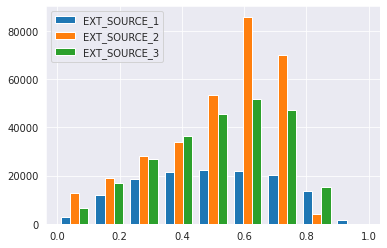

In [ ]:
#Plot features ext_source1, ext_source2, ext_source3 together
bins = np.linspace(0, 1, 10)
plt.hist([application_train['EXT_SOURCE_1'], application_train['EXT_SOURCE_2'], application_train['EXT_SOURCE_3']], bins, label=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'])
plt.legend(loc='upper left')
plt.show()

We can see that the three features follow a normal distribution. Characteristics of this distribution such as kurtosis and skewness are presented:

In [ ]:
print( 'Kurtosis (EXT_SOURCE_1): {}'.format(application_train['EXT_SOURCE_1'].kurtosis() ))
print( 'Kurtosis (EXT_SOURCE_2): {}'.format(application_train['EXT_SOURCE_2'].kurtosis() ))
print( 'Kurtosis (EXT_SOURCE_3): {}'.format(application_train['EXT_SOURCE_3'].kurtosis() ))
print( 'Skewness (EXT_SOURCE_1): {}'.format(application_train['EXT_SOURCE_1'].skew() ))
print( 'Skewness (EXT_SOURCE_2): {}'.format(application_train['EXT_SOURCE_2'].skew() ))
print( 'Skewness (EXT_SOURCE_3): {}'.format(application_train['EXT_SOURCE_3'].skew() ))

Kurtosis (EXT_SOURCE_1): -0.9651552847611118
Kurtosis (EXT_SOURCE_2): -0.2691308299026076
Kurtosis (EXT_SOURCE_3): -0.6634630539622153
Skewness (EXT_SOURCE_1): -0.06875505870176395
Skewness (EXT_SOURCE_2): -0.7935760449636996
Skewness (EXT_SOURCE_3): -0.4093904596160265


While the ext_source_1 it's almost a symmetrical distribution (skew=-0.07), the ext_source_2 has the most negative skewness and also the lowest kurtosis among the three features.

This application dataset has 121 features. All this data can be overwhelming and can make it difficult to understand the influence of each one in the target feature. Analyzing the features in this dataset, several of them are related to the client's real estate, such as total area, the number of entrances, elevators or floors. A heatmap of the correlation among these features can be plotted to helps us understand the importance of each feature. In total, 47 features are related to real estate data.

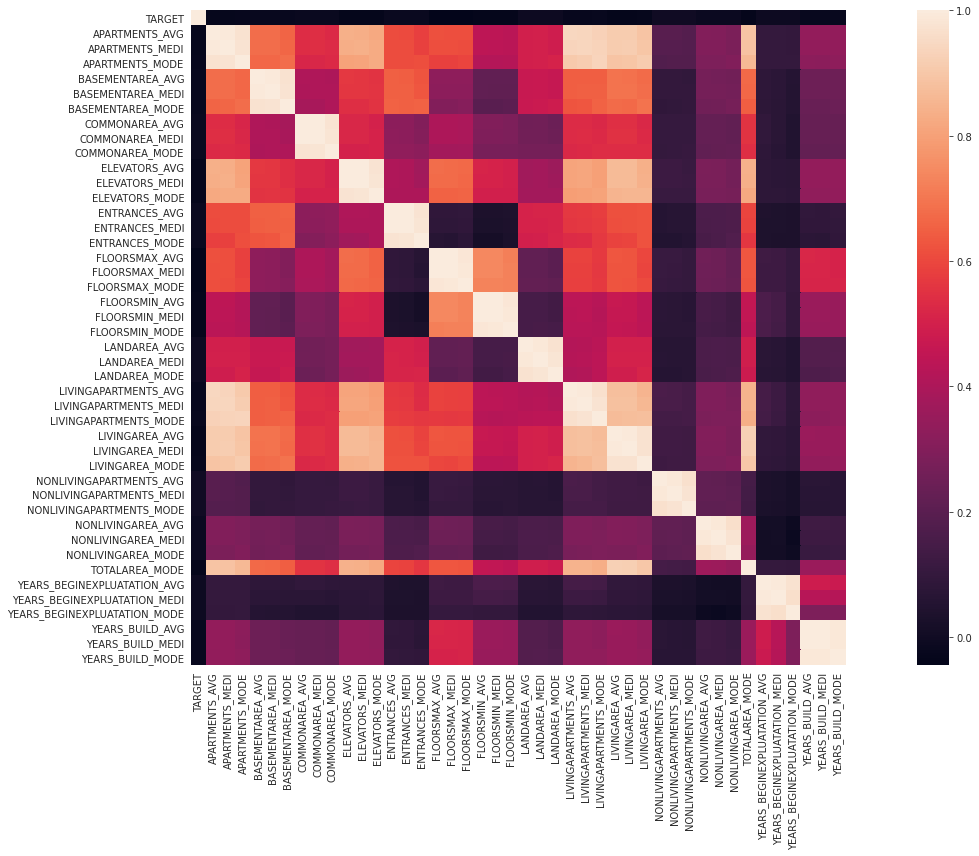

In [ ]:
#Select real estate features from the application dataset
real_estate = application_train.iloc[:,44:89]
real_estate = real_estate[sorted(list(real_estate.columns))]
#include target and id features
real_estate.insert(0, 'SK_ID_CURR', application_train['SK_ID_CURR'])
real_estate.insert(1, 'TARGET', application_train['TARGET'])
#Resize figure
plt.rcParams["figure.figsize"] = (20,12)

#Plot heatmap of the correlation
sns.heatmap(real_estate.iloc[:,1:].corr(), square=True)
plt.tight_layout()

Generate sweetviz report with EDA taking into account only the real estate features

In [ ]:
#report_re = sv.analyze(real_estate, target_feat = 'TARGET')

In [ ]:
#report_re.show_html('real_estate.html')

The file is real_estate.html

The features regarding real estate are given using three statistical measures of the data: average(_AVG), median(_MEDI) and mode (_MODE). As it can be seen in figure 3, for the same data (for example, Basement Area) the information provided (BASEMENTAREA_MODE, BASEMENTAREA_AVG, and BASEMENTAREA_MEDIAN) are highly correlated. Therefore, choosing one among the three features can be enough to convey the information to the model. This procedure can substantially reduce the number of features from the application dataset

In [ ]:
col_features_selected_real_estate = ['FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'TOTALAREA_MODE', 'LIVINGAREA_AVG', 'APARTMENTS_AVG', 'ENTRANCES_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_AVG']

In [ ]:
index_target =  ['SK_ID_CURR', 'TARGET'] 

In [ ]:
df_features_real_estate = application_train[index_target + col_features_selected_real_estate]

In [ ]:
#Report including only the selected features related to the real estate aspects.

#report_re_final = sv.analyze(df_features_real_estate, target_feat='TARGET')

In [ ]:
#report_re_final.show_html('real_estate_final.html')

The file is real_estate_final.html

Therefore, the selected real estate features were merged with the remaining numerical ones.

In [ ]:
features_numerical = list(numerical.columns)
for i in (list(real_estate.columns)):
  if i in features_numerical:
    features_numerical.remove(i)
  else:
      continue

In [ ]:
df_numerical = application_train[list(df_features_real_estate.columns)+features_numerical]

###Categorical features

Now, only the categorical features of the application dataset were analyzed concerning the target variable. 

In [ ]:
#report_cat = sv.analyze(categorical, target_feat='TARGET')

In [ ]:
#report_cat.show_html('categorical.html')

The file is categorical.html

The features that provided more information on the target variable were chosen:

In [ ]:
col_selected_categorical = ['FLAG_DOCUMENT_3','REG_CITY_NOT_LIVE_CITY','FLAG_EMP_PHONE','REG_CITY_NOT_WORK_CITY','CODE_GENDER','NAME_EDUCATION_TYPE',
                            'NAME_INCOME_TYPE','ORGANIZATION_TYPE','OCCUPATION_TYPE','FLAG_PHONE','FLAG_DOCUMENT_16','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14',
                            'FLAG_DOCUMENT_8','FLAG_DOCUMENT_18','FLAG_DOCUMENT_15','FLAG_DOCUMENT_9','FLAG_DOCUMENT_11']

In [ ]:
df_categorical = application_train[index_target+col_selected_categorical]

In [ ]:
#Report including only the selected features related to the real estate aspects.
#report_cat_final = sv.analyze(df_categorical, target_feat='TARGET')

In [ ]:
#report_cat_final.show_html('categorical_final.html')

##Bureau Dataset

Inclusion of target and ID variables into the Bureau dataset


In [ ]:
bureau = pd.merge(bureau, application_train[index_target], on='SK_ID_CURR', how= 'left')

A Sweetviz report can be generated. However, the analysis will not comprise the target variables, because this dataset includes some clients that are not included in the application dataset, therefore, there is no value of target for these clients.

In [ ]:
#report = sv.analyze(bureau)

In [ ]:
#report.show_html('bureau.html')

The file name is bureau.html

To have a wide view of the number of missing values in this dataset, the missingno library can be used. Applying the function '.bar(DataFrame)', it can be observed how much data is incomplete in each feature.

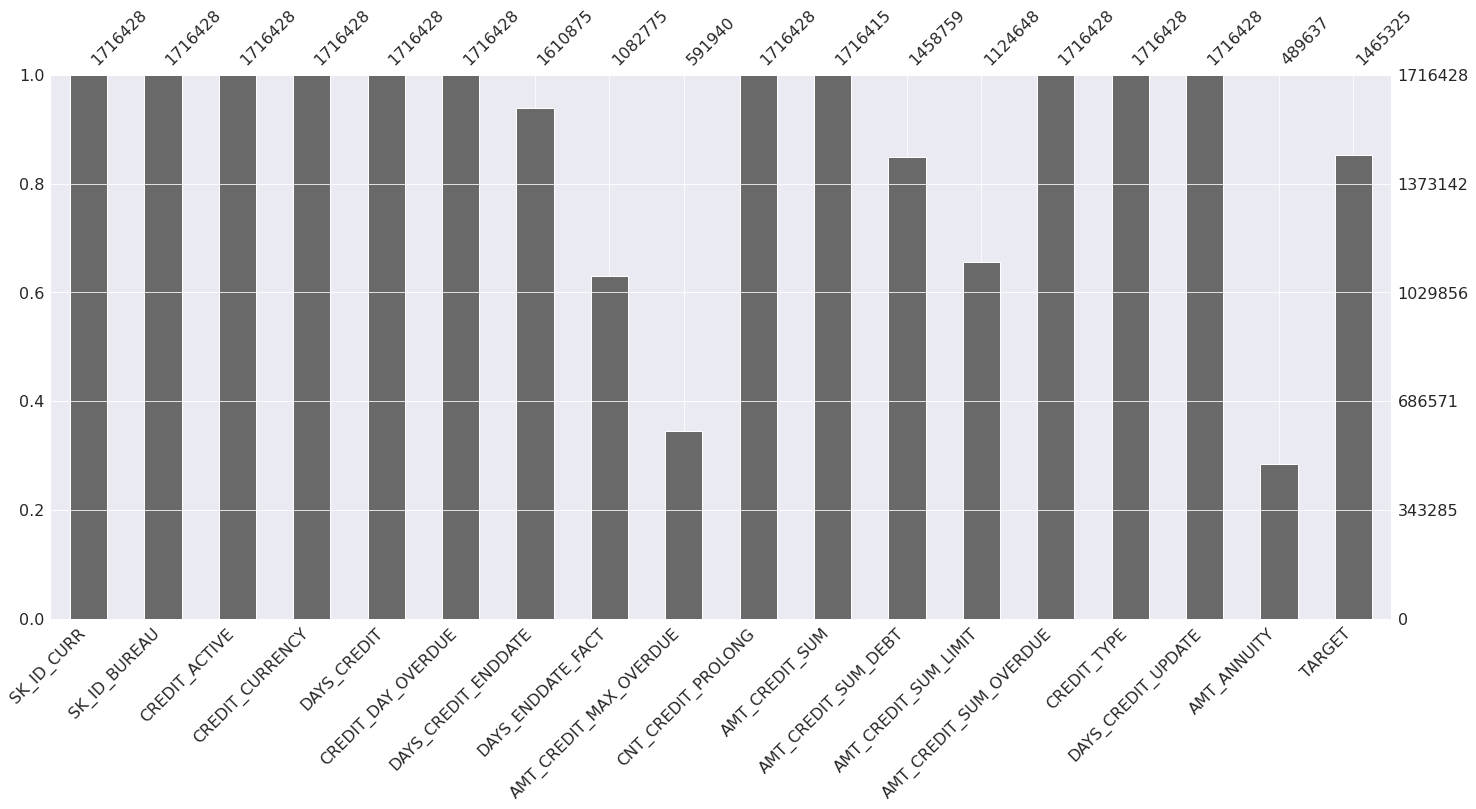

In [ ]:
ms.bar(bureau)

The features AMT_ANNUITY and AMT_CREDIT_MAX_OVERDUE do not have half of the data complete. Therefore, these features will probably be discarded. Another function of the missingno library is .heatmap(), which shows the correlation between the presence or absence of one feature and the presence of a second one:

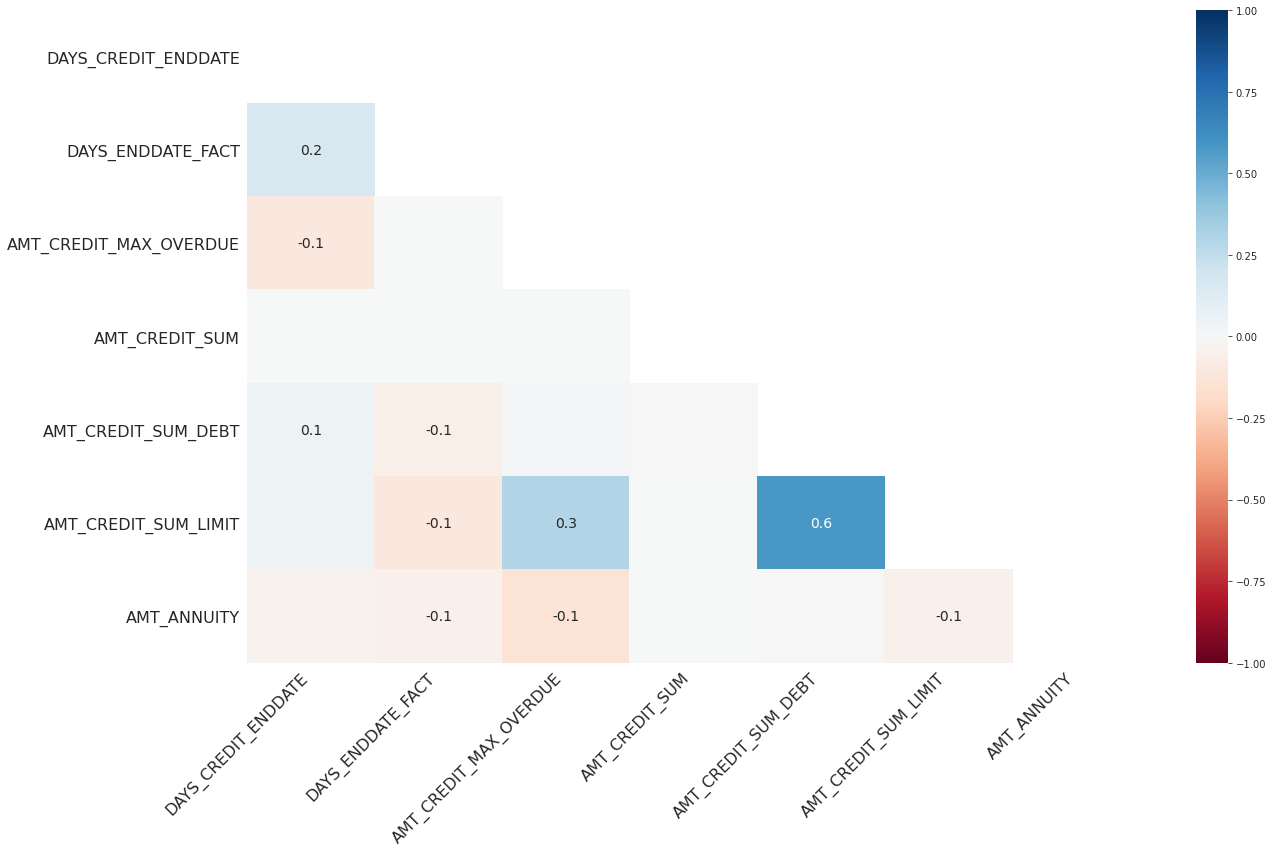

In [ ]:
ms.heatmap(bureau.drop('TARGET', axis=1), filter='bottom')

The features not presented in the graphs are those that do not have any missing values. The missing values from AMT_CREDIT_SUM_LIMIT and AMT_CREDIT_SUM_DEBT have a high positive correlation; therefore, this information can be applied to decide which one to use.

##Bureau Balance

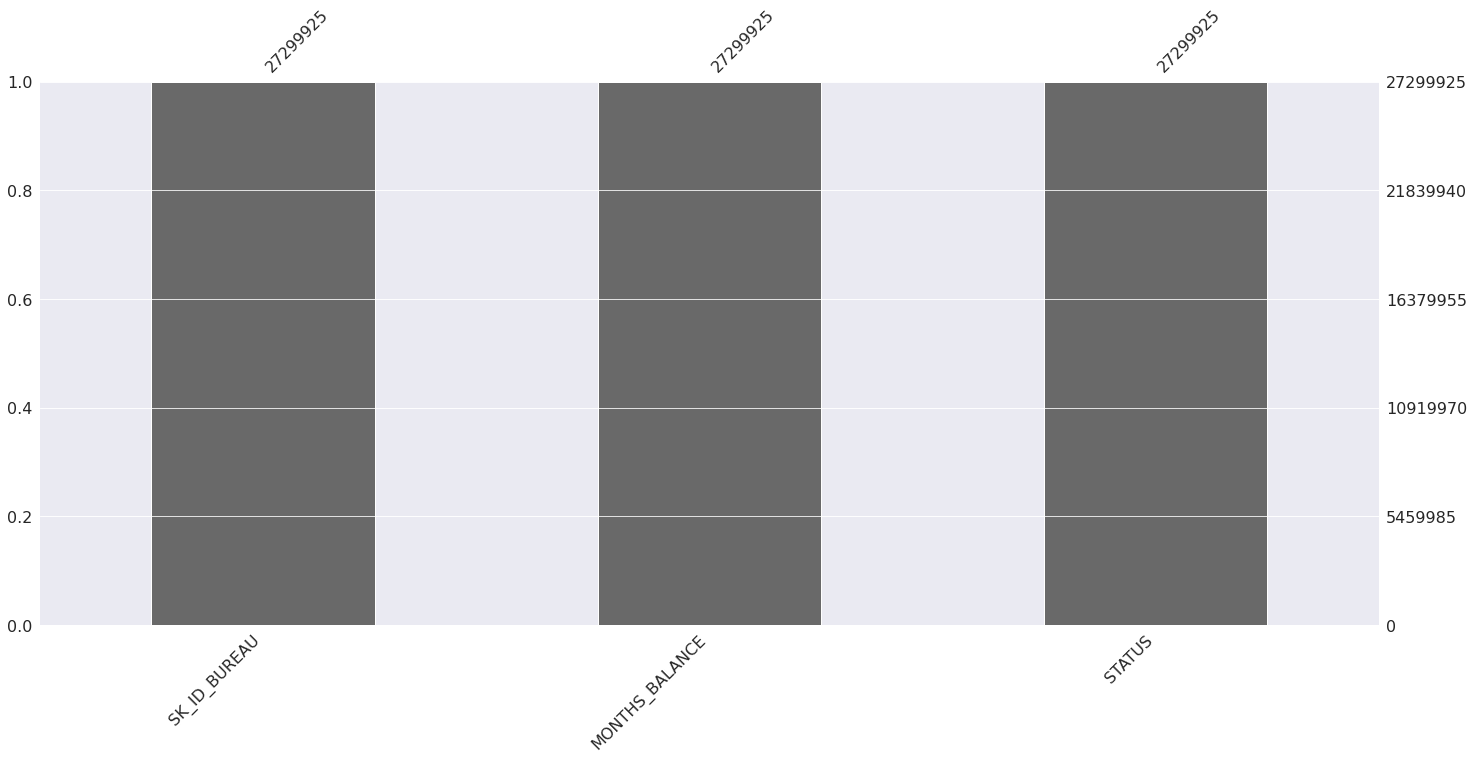

In [ ]:
ms.bar(bureau_balance)

This dataset refers to transactional data of the monthly balance of each client; therefore, this data needs to be aggregated before an analysis can be conducted. The status feature is a categorical feature that has to be encoded given its multiple values. Therefore, some data prep will be necessary at this stage.

In [ ]:
bureau_balance_en = pd.get_dummies(bureau_balance)

Afterwards, these data can be aggregated using the mean value of each encoded feature in relation to each client. 

In [ ]:
c = list(bureau_balance_en.columns)
c.remove('MONTHS_BALANCE')
c.remove('SK_ID_BUREAU' )

In [ ]:
bb_mean = (bureau_balance_en.drop(['MONTHS_BALANCE'], axis=1).groupby('SK_ID_BUREAU', as_index=True).agg(['mean']))
bb_count = (bureau_balance_en[['SK_ID_BUREAU','MONTHS_BALANCE']].groupby('SK_ID_BUREAU', as_index=True).agg(['count']))

In [ ]:
bb_mean = organize_agg(bb_mean, 'mean', 'bureau_balance')

In [ ]:
bb_count = organize_agg(bb_count, 'count', 'bureau_balance')

In [ ]:
bureau_balance_en = pd.merge(bb_mean, bb_count, on='SK_ID_BUREAU', how='left')

In [ ]:
del bb_mean

In [ ]:
del bb_count

Inclusion of target and ID variables into the Bureau dataset

In [ ]:
bureau_balance_id = pd.merge(bureau_balance_en, bureau[['SK_ID_BUREAU', 'TARGET']], on='SK_ID_BUREAU', how='left')

In [ ]:
del bureau_balance_en

As we can see from the plot of the missing value, this dataset is complete, and the only data missing are those relative to the Target variable imported from the application dataset. To better understand the relationships among the features from this dataset and the target, the rows with no target information will be dropped and the features will be analyzed with the sweetviz.

In [ ]:
#report_bureau_balance = sv.analyze(bureau_balance_id.dropna(subset=['TARGET']), target_feat='TARGET')

In [ ]:
#report_bureau_balance.show_html('bureau_balance.html')

##Previous application

This dataset comprises various data from clients obtained from previous applications. Taking a look into the missing values, it can be noted that several features don't have even half of the data present. Also, there are categorical and numerical features.


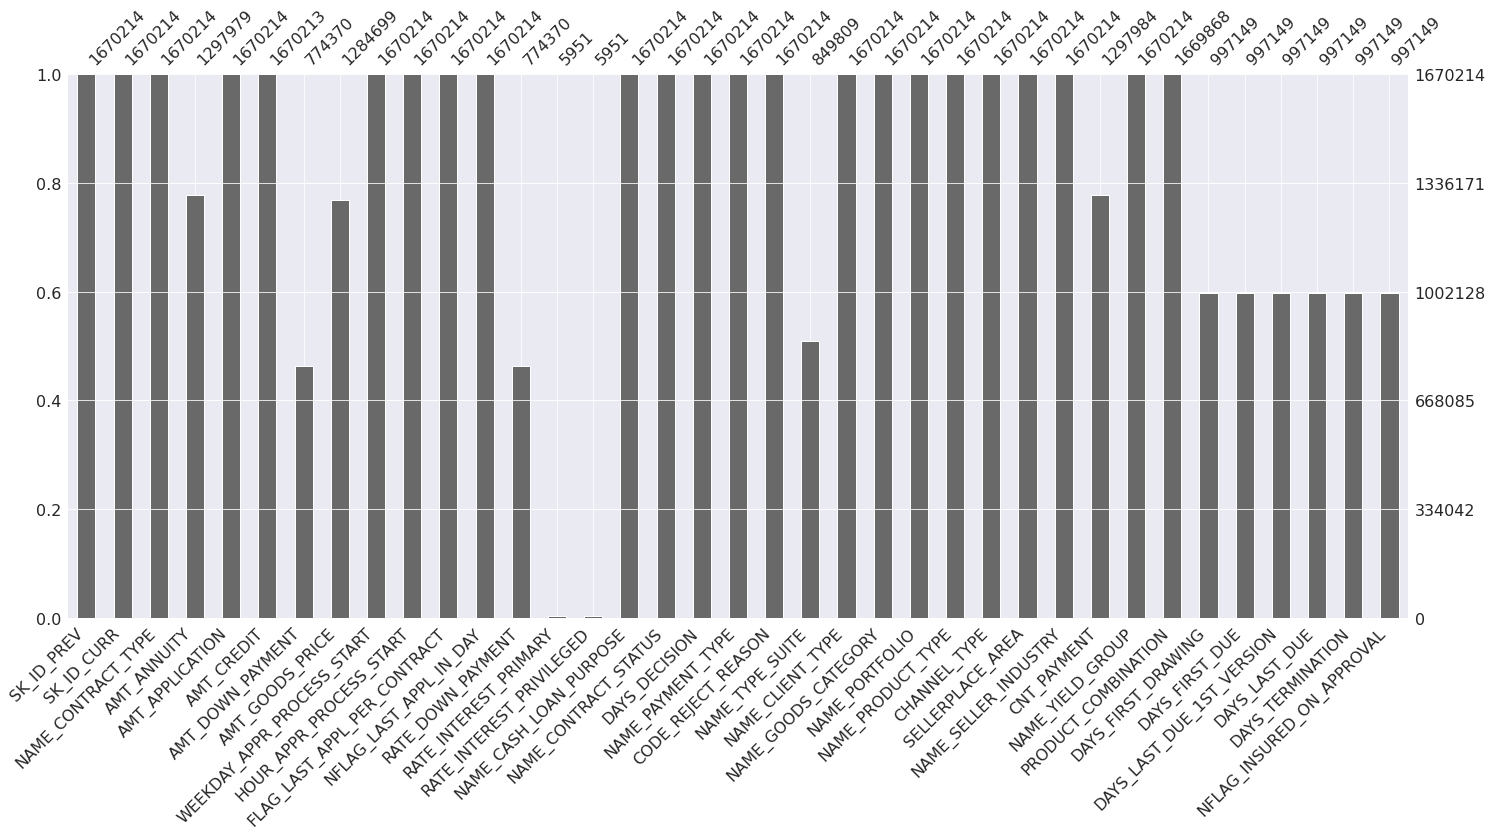

In [ ]:
ms.bar(previous_application)

The previous application dataset needs the aggregation of some rows, just like the 'bureau balance' dataset. This aggregation is to make sure that each row refers to one client.

Among the categorical features of this dataset, one must be observed: the feature NAME_CONTRACT_STATUS has information regarding the approval of the application. Therefore, the dataset can be analysed using this categorical feature as a proxy for the target variable

In [ ]:
previous_application['Approved'] = previous_application['NAME_CONTRACT_STATUS']=='Approved'

In [ ]:
#report_previous_application = sv.analyze(previous_application, target_feat='Approved')

In [ ]:
#report_previous_application.show_html('previous application_app.html')

##Credit Card Balance

First, let's check for the number of missing values in the dataset


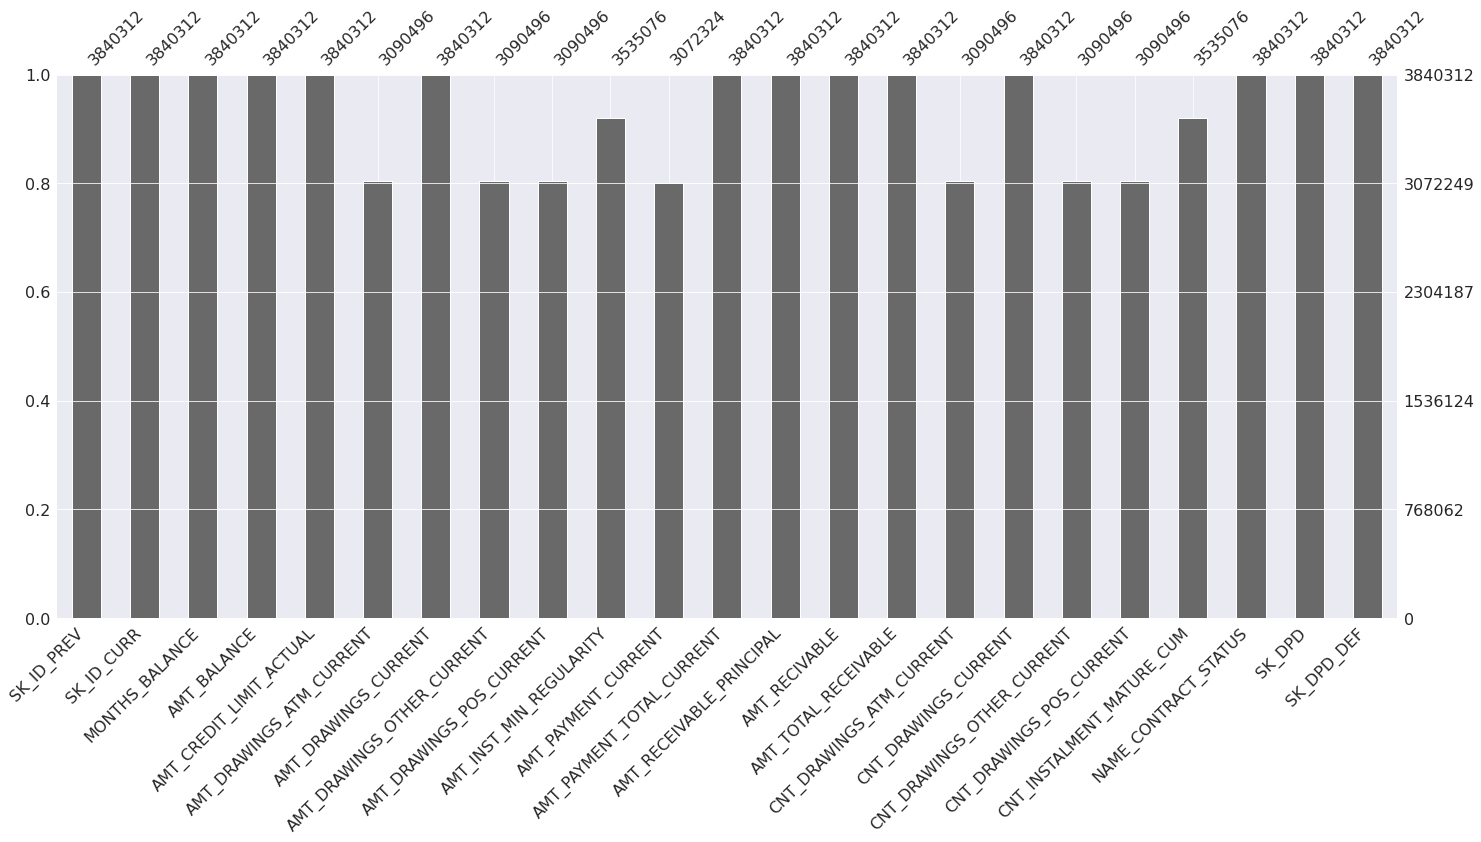

In [ ]:
ms.bar(credit_card_balance)

As we can see, the number of missing values is low. So it should not be a problem

As with other datasets before, this one also needs aggregation due to the multiples entries that are related to one client. In this case, two aggregations are needed, given that, multiple rows are referring to one past application, and multiple past applications referring to one client. In this case, the aggregation will consider the maximum, minimum and average value of the features.

In [ ]:
prev_cc_agg = credit_card_balance.drop('SK_ID_CURR', axis=1).groupby('SK_ID_PREV', as_index=True).agg(['max', 'min', 'mean'])

In [ ]:
prev_cc_agg = organize_agg(prev_cc_agg, ['max', 'min', 'mean'], 'prev_cc_agg')

In [ ]:
prev_cc_agg = pd.merge(prev_cc_agg, credit_card_balance[['SK_ID_PREV', 'SK_ID_CURR']], on='SK_ID_PREV', how='left')

In [ ]:
prev_cc_agg = pd.merge(prev_cc_agg, application_train[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

In [ ]:
#report_cc = sv.analyze(prev_cc_agg.dropna(subset=['TARGET']), target_feat='TARGET')

In [ ]:
#report_cc.show_html('credit_balance_app.html')

Through this report, we can observe the features that have the highest correlation with the target variable and select these for further data preparation.

##Installments

The instalments dataset are also related to the previous application dataset and presents the same characteristics as the credit card balance. Therefore, a similar procedure will be applied here to perform the EDA of this dataset

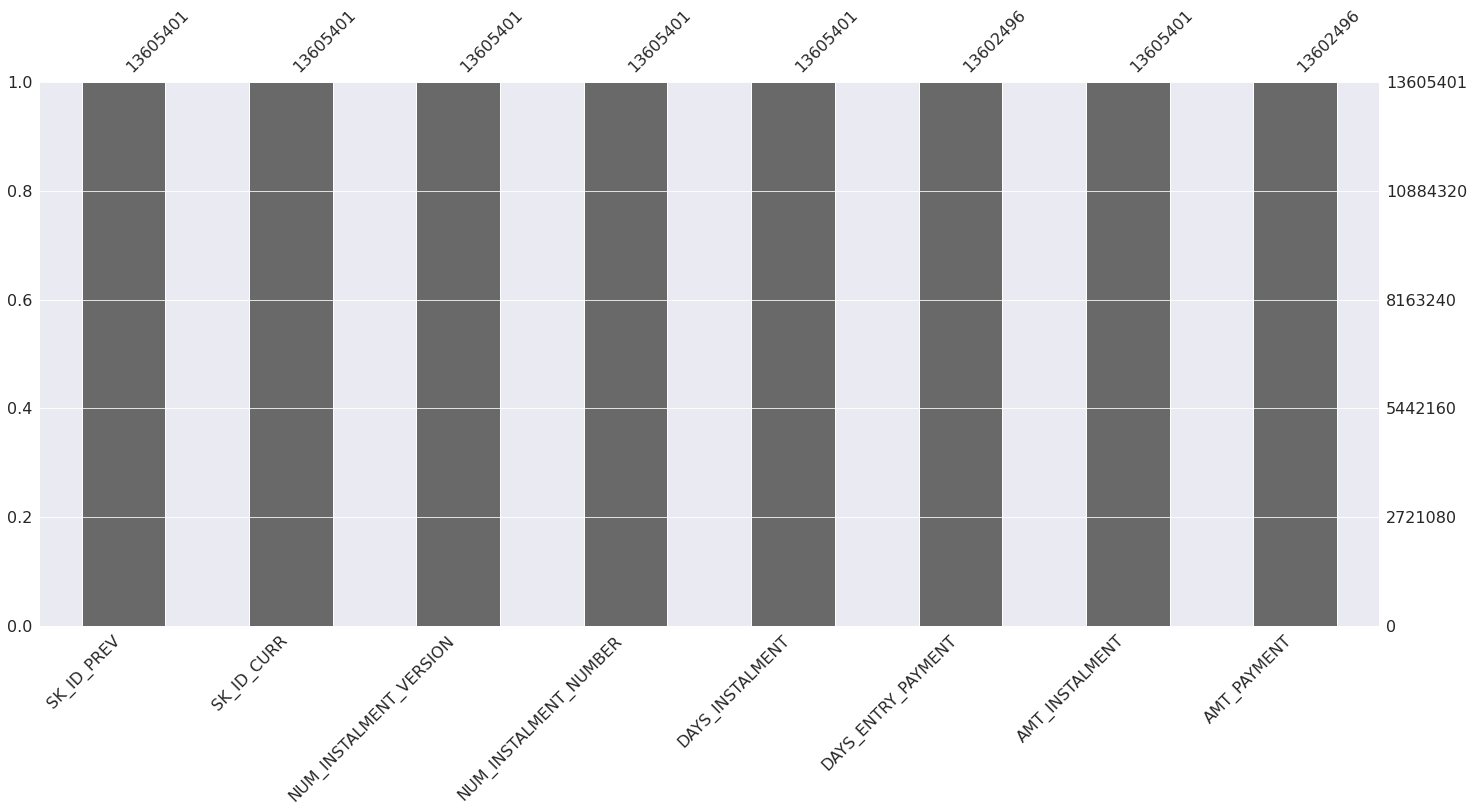

In [ ]:
ms.bar(installments_payments)

In [ ]:
installments_payments_agg = installments_payments.groupby('SK_ID_PREV').agg(['min', 'max', 'mean'])

In [ ]:
installments_payments_agg = organize_agg(installments_payments_agg,['min', 'max', 'mean'], 'installments')

In [ ]:
installments_payments_agg.drop(['installments_SK_ID_CURR_min', 'installments_SK_ID_CURR_max'], inplace=True, axis=1)

In [ ]:
installments_payments_agg.rename(columns={'installments_SK_ID_CURR_mean':'SK_ID_CURR'}, inplace=True)

In [ ]:
installments_payments_agg = pd.merge(installments_payments_agg, application_train[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

In [ ]:
#report_installments = sv.analyze(installments_payments_agg.dropna(subset=['TARGET']), target_feat='TARGET')

In [ ]:
#report_installments.show_html('installments.html')

##POS Dataset

Similar to the dataset before, the POS Dataset also contains transactional data regarding previous applications from the clients. Therefore, this dataset needs the same aggregation as the one before. But first, let's check for missing data.

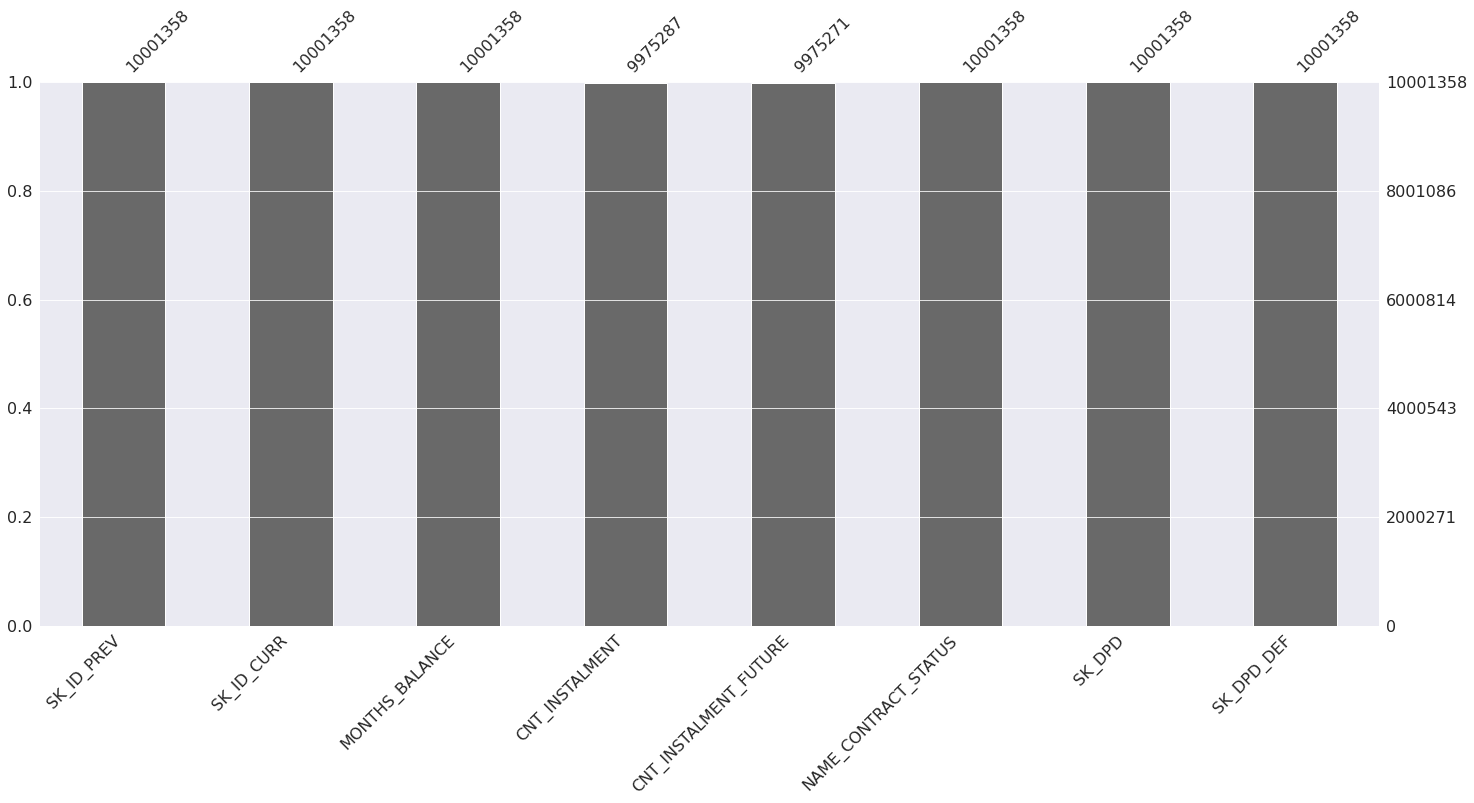

In [ ]:
ms.bar(pos_cash_balance)

There is a low number of missing values in this dataset. 

The aggregation of the data is presented as follows:


In [ ]:
pos_agg = pos_cash_balance.drop('SK_ID_CURR', axis=1).groupby('SK_ID_PREV').agg(['min', 'max', 'mean'])

In [ ]:
pos_agg = organize_agg(pos_agg,['min', 'max', 'mean'], 'pos')

In [ ]:
pos_agg = pd.merge(pos_agg, pos_cash_balance[['SK_ID_PREV','SK_ID_CURR']], on='SK_ID_PREV', how='right')

In [ ]:
pos_agg = pd.merge(pos_agg, application_train[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

In [ ]:
report_pos = sv.analyze(pos_agg.dropna(subset=['TARGET']), target_feat='TARGET')

                                             |          | [  0%]   00:00 -> (? left)

In [ ]:
report_pos.show_html('pos_target.html')

The internal aggregations of datasets shown here were necessary to conduct an Exploratory Data Analysis seeking to identify the features that most influences the target variable.

The files resulting from the sweetviz report are provided on GitHub.
